# Agentic fighters

## Exercise 3 - LangGraph for simplicity

### Graphs

![Graphs](./../images/Graphs.png)

Conceptos importantes:

- nodos
- relaciones
- estado
- persistencia

In [1]:
import os

In [2]:
if not os.environ.get("OPENAI_API_KEY"):
    raise ValueError("Please set OPENAI_API_KEY environment variable")

LLM_MODEL = "gpt-4o-mini"
LLM_TEMPERATURE = 0

In [3]:
from IPython.display import Markdown
from typing import TypedDict, Annotated
import operator

from langchain_openai import ChatOpenAI
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.graph import StateGraph, END

In [4]:
base_model = ChatOpenAI(model=LLM_MODEL, temperature=LLM_TEMPERATURE)

#### Estado

In [5]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

#### Tools

In [6]:
if not os.environ.get("TAVILY_API_KEY"):
    raise ValueError("Please set OPENAI_API_KEY environment variable")

tool = TavilySearchResults(max_results=4)
print(type(tool))
print(tool.name)

<class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>
tavily_search_results_json


#### Workflow con grafo (nodos y relaciones)

In [7]:
class Agent:
    # General architecture of the graph
    ####################################
    def __init__(self, model, tools, system=""):
        self.system = system
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

        graph = StateGraph(AgentState)

        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)

        graph.add_conditional_edges(
            "llm",
            self.exists_action,
            {True: "action", False: END}
        )
        graph.add_edge("action", "llm")

        graph.set_entry_point("llm")

        self.graph = graph.compile()


    # Main nodes
    #############
    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)

        return {'messages': [message]}

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if t['name'] not in self.tools:
                print("\n ....bad tool name....")
                result = "bad tool name, retry"
            else:
                result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")

        return {'messages': results}


    # Conditional edges
    ####################
    def exists_action(self, state: AgentState):
        result = state['messages'][-1]

        return len(result.tool_calls) > 0

In [8]:
prompt = """Eres un asistente de búsqueda inteligente. Utiliza el motor de búsqueda para buscar información. \
Te está permitido hacer múltiples llamadas (ya sea juntas o secuenciales). \
Solo debes buscar información cuando estés seguro de lo que necesitas. \
Está permitido buscar información antes de hacer una pregunta para clarificar.
"""

abot = Agent(base_model, [tool], system=prompt)

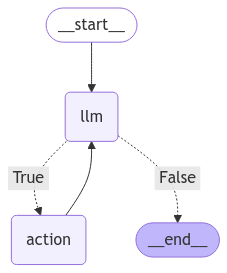

In [9]:
from IPython.display import Image

Image(abot.graph.get_graph().draw_mermaid_png())

In [10]:
messages = [HumanMessage(content="¿Que tiempo hace en Valencia?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'tiempo actual en Valencia'}, 'id': 'call_O84T4m2s8jh80MrgP1bdJCZK', 'type': 'tool_call'}
Back to the model!


In [11]:
result

{'messages': [HumanMessage(content='¿Que tiempo hace en Valencia?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_O84T4m2s8jh80MrgP1bdJCZK', 'function': {'arguments': '{"query":"tiempo actual en Valencia"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 147, 'total_tokens': 170, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_13eed4fce1', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-8309dd6e-ae88-4829-9c4d-622344da91a7-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'tiempo actual en Valencia'}, 'id': 'call_O84T4m2s8jh80MrgP1bdJCZK', 'type': 'tool_call

In [12]:
result['messages'][-1].content

'Actualmente, el tiempo en Valencia es el siguiente:\n\n- **Temperatura**: Alrededor de 18°C (65°F).\n- **Condiciones**: Soleado durante la tarde, con algunas nubes y claros por la noche.\n- **Viento**: Del noreste a 11 km/h (aproximadamente 6 mi/h).\n- **Índice UV**: Moderado, con un máximo de 4.\n\nPara más detalles, puedes consultar [AccuWeather](https://www.accuweather.com/es/es/valencia/310683/current-weather/310683) o [Weather and Radar](https://es.weatherandradar.com/tiempo/valencia/6102628).'

In [13]:
messages = [HumanMessage(content="What is the weather in Valencia and Madrid?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Valencia'}, 'id': 'call_2dp3glQR9nl1BqTG4TImd6Tm', 'type': 'tool_call'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Madrid'}, 'id': 'call_z1C5MHCrX6aPIEdDkvzr7GL0', 'type': 'tool_call'}
Back to the model!


In [14]:
Markdown(result['messages'][-1].content)

### Current Weather

#### Valencia
- **Temperature**: 14.3°C (57.7°F)
- **Condition**: Partly cloudy
- **Wind**: 6.0 mph (9.7 kph) from the North
- **Humidity**: 82%
- **Pressure**: 1016 mb
- **Visibility**: 9 km

#### Madrid
- **Temperature**: 10.4°C (50.7°F)
- **Condition**: Clear
- **Wind**: 2.2 mph (3.6 kph) from the Southeast
- **Humidity**: 76%
- **Pressure**: 1015 mb
- **Visibility**: 10 km

For more detailed forecasts, you can check the following links:
- [Valencia Weather](https://www.weatherapi.com/)
- [Madrid Weather](https://www.weatherapi.com/)

In [15]:
"""
query = "¿Qué equipo va último en la liga de fútbol española de este año? ¿De qué ciudad es ese equipo? ¿Cuál es la provincia que está al sur de dicha ciudad? Responde a todas las preguntas."
messages = [HumanMessage(content=query)]

abot = Agent(base_model, [tool], system=prompt)
result = abot.graph.invoke({"messages": messages})
"""

'\nquery = "¿Qué equipo va último en la liga de fútbol española de este año? ¿De qué ciudad es ese equipo? ¿Cuál es la provincia que está al sur de dicha ciudad? Responde a todas las preguntas."\nmessages = [HumanMessage(content=query)]\n\nabot = Agent(base_model, [tool], system=prompt)\nresult = abot.graph.invoke({"messages": messages})\n'

In [16]:
query = "Who won the super bowl in 2024? In what state is the winning team headquarters located? \
What is the GDP of that state? Answer each question."
messages = [HumanMessage(content=query)]

abot = Agent(base_model, [tool], system=prompt)
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Super Bowl 2024 winner'}, 'id': 'call_b5ETNrxyy5pALUBJlcIrFinm', 'type': 'tool_call'}
Back to the model!
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Kansas City Chiefs headquarters location'}, 'id': 'call_IGM3sxCq0meTPU9NOxvEQoXA', 'type': 'tool_call'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'GDP of Missouri'}, 'id': 'call_MhOFxpYvyE98DeEkXRvuR43y', 'type': 'tool_call'}
Back to the model!


In [17]:
print(result['messages'][-1].content)

1. **Who won the Super Bowl in 2024?**
   - The Kansas City Chiefs won the Super Bowl in 2024, defeating the San Francisco 49ers with a score of 25-22 in overtime.

2. **In what state is the winning team's headquarters located?**
   - The Kansas City Chiefs are headquartered in Missouri.

3. **What is the GDP of that state?**
   - As of 2023, the GDP of Missouri is approximately $348.5 billion.
